## Predicting Rainfall in Vancouver

### Introduction

Vancouver, one of Canada's rainiest cities, averages over 1 metre of total rainfall per year<sup>[1]</sup>. Daily weather forecasts have become essential for residents to gauge the amount of rainfall likely and plan their daily activities. Currently, meteorologists use complex, resource-heavy computations based on Lewis Richardson's 1922 numerical process for weather prediction<sup>[2]</sup>. However, a [2021 article by Colorado State University](https://source.colostate.edu/ai-and-machine-learning-are-improving-weather-forecasts-but-they-wont-replace-human-experts/#:~:text=Some%20studies%20have%20shown%20that,computing%20power%20the%20models%20require.) proposed that *machine-learning-based* forecast systems could predict the weather just as well as the numerical ones, but at a fraction of the computing resources required<sup>[2]</sup>. Our analysis aims to investigate this possibility.

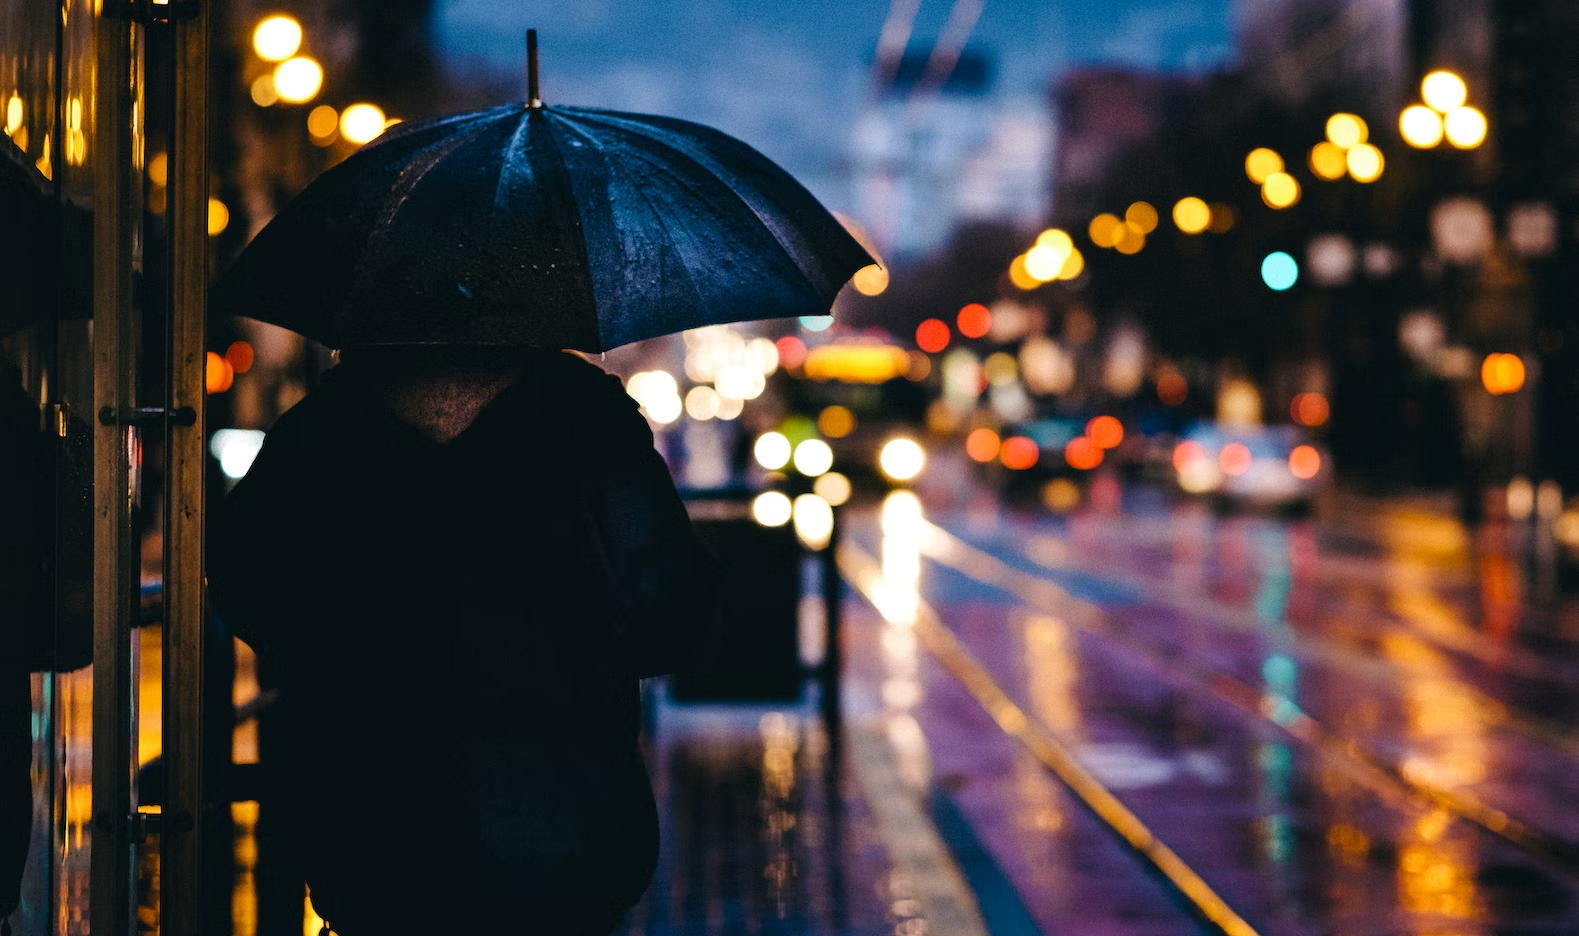
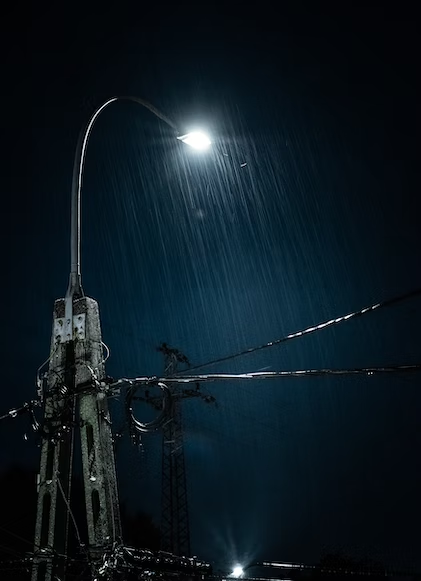

Source: [image[1]](https://unsplash.com/photos/uFomxGheuGk);  [image[2]](https://unsplash.com/photos/_zUAcIvs-ME)

For simplicity, our model will only deal with rainfall, considering its relevance to Vancouver. We will investigate whether it is possible to predict the rainfall amount on a given day of the year, using regular weather-station measurements (eg: temperature, pressure). For training and testing our model, we use a dataset from Vancouver Weather Stats<sup>[3]</sup>, containing Vancouver's weather data for the past decade (2011-2021).

### Preliminary Data Analysis

First, we load the five packages (`tidyverse`,`haven`,`lubridate`,`tidymodels`,`cowplot`), which will be useful in the upcoming phases of our analysis.

In [1]:
## needed packages
library(tidyverse)
library(haven)
library(lubridate)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   mask

Our dataset is formatted as a `.csv` file with headers. We will use `read_csv()` to load our data in for wrangling. We must first filter in on observations between 2011 to 2021 (inclusive), since the data is not complete for values outside that range.

In [2]:
weather <- read_csv("https://raw.githubusercontent.com/taimagher/Weather-Stats-Report/main/weatherstats_vancouver_daily_2001.csv") |>
            filter(year(date) >= 2011 & year(date) <= 2021) |>
            arrange(date)

Rows: 4400 Columns: 70
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (62): max_temperature, avg_hourly_temperature, avg_temperature, min_tem...
lgl   (5): solar_radiation, max_cloud_cover_4, avg_hourly_cloud_cover_4, avg...
date  (1): date
time  (2): sunrise, sunset

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


To help gauge what wrangling is required, let's `slice()` to preview the first and last 3 rows of our data.  

In [3]:
weather |> head(3)
weather |> tail(3)

date,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_humidex,min_windchill,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,⋯,avg_cloud_cover_4,min_cloud_cover_4,max_cloud_cover_8,avg_hourly_cloud_cover_8,avg_cloud_cover_8,min_cloud_cover_8,max_cloud_cover_10,avg_hourly_cloud_cover_10,avg_cloud_cover_10,min_cloud_cover_10
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011-01-01,3.3,-1.62,-1.55,-6.4,NA,-10,92,76.1,74.0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2011-01-02,3.4,-1.08,-1.30,-6.0,NA,-8,95,82.6,81.5,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2011-01-03,4.3,-0.44,-0.30,-4.9,NA,-8,95,86.4,82.0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


date,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_humidex,min_windchill,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,⋯,avg_cloud_cover_4,min_cloud_cover_4,max_cloud_cover_8,avg_hourly_cloud_cover_8,avg_cloud_cover_8,min_cloud_cover_8,max_cloud_cover_10,avg_hourly_cloud_cover_10,avg_cloud_cover_10,min_cloud_cover_10
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-12-29,-4.1,-7.09,-7.90,-11.7,NA,-18,92,69.2,70.0,⋯,NA,NA,8,4.6,4.0,0,NA,NA,NA,NA
2021-12-30,-0.7,-4.03,-4.39,-8.1,NA,-14,94,85.0,80.0,⋯,NA,NA,8,4.6,4.5,1,NA,NA,NA,NA
2021-12-31,-2.5,-6.64,-6.70,-10.9,NA,-17,93,74.8,72.5,⋯,NA,NA,8,3.5,4.5,1,NA,NA,NA,NA



###### *Tables 2.1 and 2.2: Preview of first 3 and last 3 rows of weather dataset*


*Tables 2.1 & 2.2* contain columns with maximum and minimum readings recorded for each day. 
Due to the possibility of outliers, training the model on extreme values is unreasonable. We will therefore use `select` to extract the columns `date`, `rain`, and only the measurement columns whose names begin with `avg`.

In [4]:
selected_rain_data <- weather |>
                    select(date, starts_with('avg'), rain) 

Some rows contain `NA` values for `rain`, which could cause the _KNN_ regression algorithm to unintentionally produce `NA` when calculating the mean `rain` of nearest neighbors. We will filter out these rows using `is.na(rain) == FALSE` to avoid this.

In [5]:
rain_data <- selected_rain_data |>
                    filter(is.na(rain) == FALSE)

Let us now use `group_by()` and `summarize()` to see the total rainfall for each year.

In [6]:
total_rain_year <- rain_data |> 
                    group_by(year(date)) |>
                    summarize(sum(rain))
colnames(total_rain_year) <- c("Year", "Total Rainfall (mm)")
total_rain_year

Year,Total Rainfall (mm)
<dbl>,<dbl>
2011,1045.2
2012,1161.3
2013,905.0
2014,1236.8
2015,1139.2
2016,1279.6
2017,1172.9
2018,1325.4
2019,934.1


###### *Table 2.3: Vancouver's Total Yearly Rainfall from 2011 to 2021*

*Table 2.3* displays the consistently significant rainfall amounts in Vancouver, reinforcing the practical applications of us conducting this analysis for Vancouver.

We will now begin building our model. Firstly, we need to split our data to ensure our eventual testing is fair. We use `initial_split()` with a 75%-25% training-testing split, for balance between well-trainedness and accurate testing. We also maintain proportions of different `rain` values when we split.

We set the seed **78** here so that all of our analysis's following steps are reproducible.

In [7]:
set.seed(78)

rain_split <- initial_split(rain_data, prop = 0.75, strata = rain)
rain_training <- training(rain_split)
rain_testing <- testing(rain_split)

Going forth, we use only training data until our testing phase, to prevent unfairly suiting our model to our testing data. 

### Choosing Predictors

Before training our model, we need to identify suitable predictors. 

Our aim is to predict rainfall (in mm) on a particular day of the year given some usual weather measurements. We know that rain changes seasonally, and we confirm this with a scatterplot analyzing the relationship between these two variables (*Figure 3.1*).

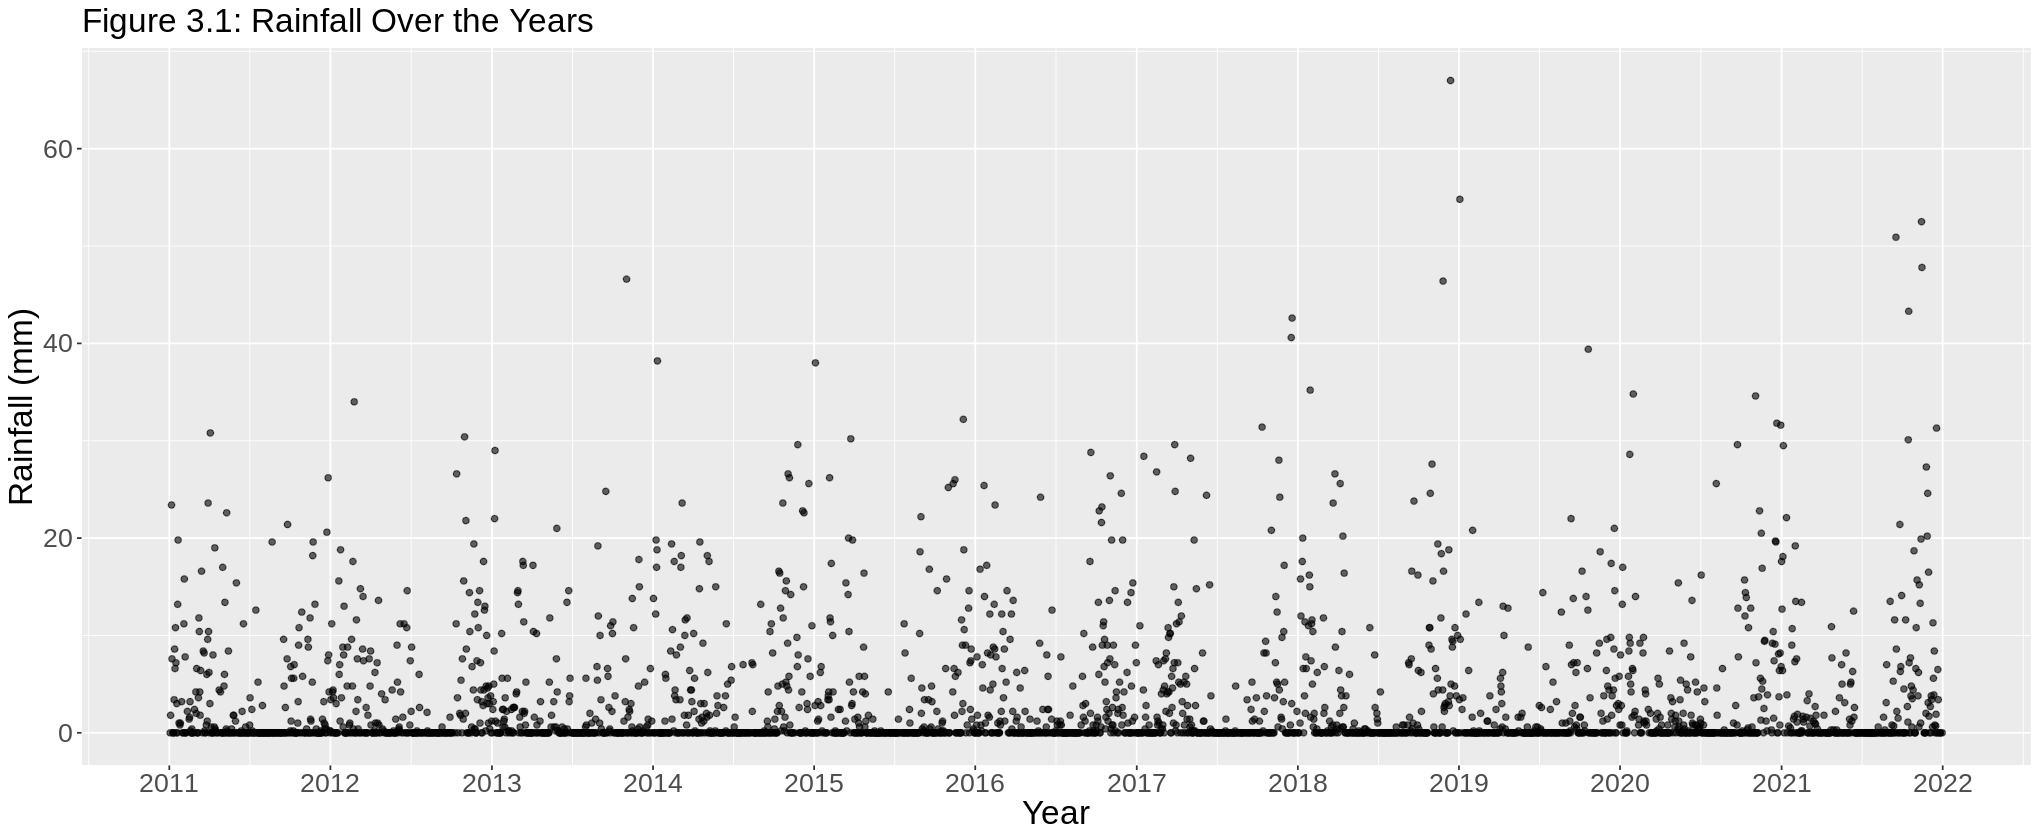

In [8]:
options(repr.plot.width = 17, repr.plot.height = 7)

rain_over_time_plot <- ggplot(rain_training, aes(x = date, y = rain)) + 
                        geom_point(alpha = 0.6) + 
                        labs(x = "Year", y = "Rainfall (mm)", subtitle = "Figure 3.1: Rainfall Over the Years") +
                        scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
                        theme(text = element_text(size = 20))
                     
rain_over_time_plot

*Figure 3.1* confirms that rainfall indeed follows a seasonal pattern, peaking at beginning and end of each year, and dropping around the middle. This suggests that the actual day of the year would be useful when predicting. We design a new predictor called `yday`, which gives a value from 0 to 366 (based on day of the year) for each of our observations. The function `yday` from the `lubridate` package can be used to mutate the existing `date` column, performing the conversion appropriately and handling leap years.

In [9]:
rain_training <- rain_training |> mutate(yday = yday(date))
rain_testing <- rain_testing |> mutate(yday = yday(date))

*Figure 3.2* below visualizes the variation of rainfall against this new predictor, capturing the seasonal pattern. 

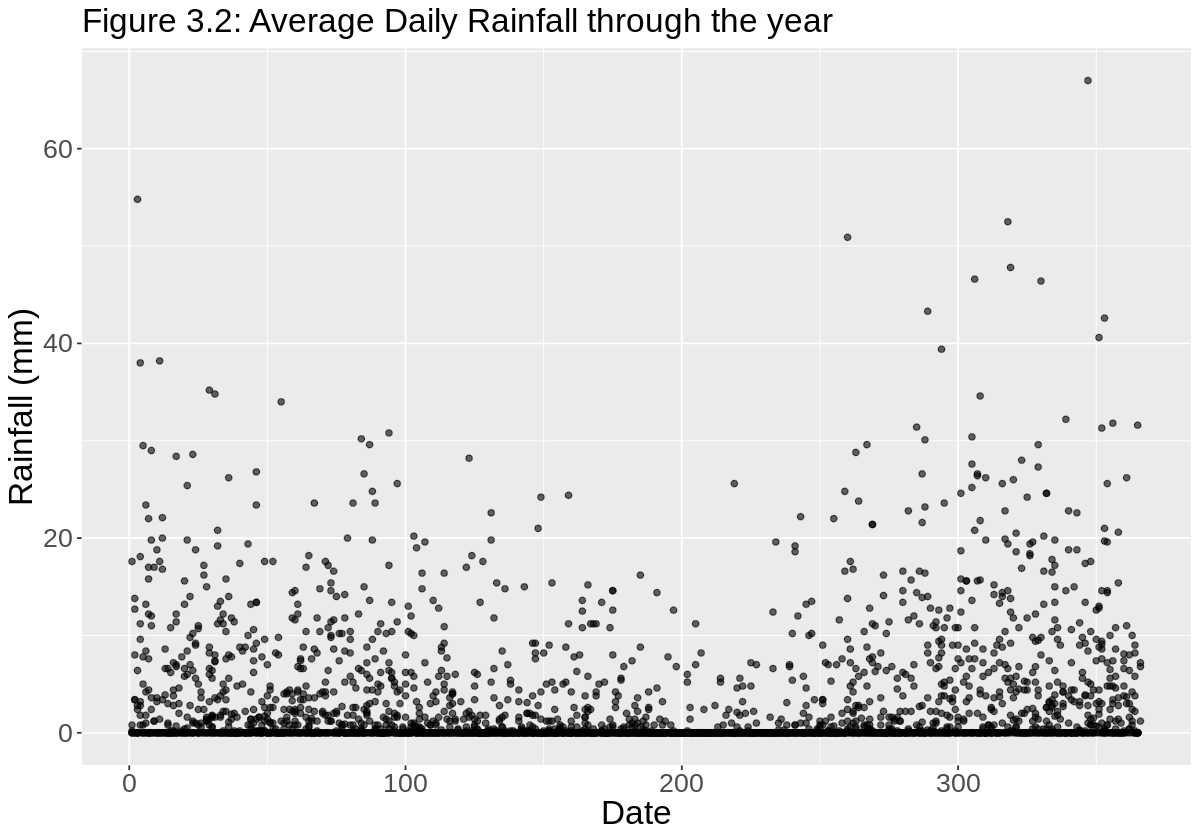

In [10]:
options(repr.plot.width = 10, repr.plot.height = 7)

rain_yday_plot <- ggplot(rain_training, aes(x = yday, y = rain)) + 
                        geom_point(alpha = 0.6) + 
                        labs(x = "Date", y = "Rainfall (mm)", subtitle = "Figure 3.2: Average Daily Rainfall through the year") +
                        theme(text = element_text(size = 20))
                     
rain_yday_plot

Next, we also consider some meteorological predictors. According to [The National Oceanic and Atmospheric Administration](https://www.noaa.gov/education/resource-collections/weather-atmosphere/weather-observations#:~:text=Temperature%2C%20humidity%2C%20precipitation%2C%20air,first%20weather%20observations%20were%20recorded), the key observations used to predict weather patterns are temperature, humidity, wind speed, air pressure, and wind direction<sup>[4]</sup>. 

Since wind direction is not quantifiable, we cannot use it to train our _KNN_ (K-nearest neighbors) regression model. The other variables, however, can be used as predictors.

Below, *Figures 3.3 - 3.6* visualize the relationship between the rainfall (`rain`) and these potential measurement predictors: temperature, relative humidity, windspeed, and pressure (`avg_temperature`, `avg_relative_humidity`, `avg_wind_speed`, `avg_pressure_station`).

In [11]:
options(repr.plot.width = 19, repr.plot.height = 6)

rain_temperature_plot <- ggplot(rain_training, aes(x = avg_temperature, y = rain)) + 
                         geom_point(alpha= 0.6) + 
                         labs(x = "Temperature (°C)", y = "Rainfall (mm)", subtitle = "Figure 3.3") +
                        theme(text = element_text(size = 20))


rain_humidity_plot <- ggplot(rain_training, aes(x = avg_relative_humidity, y = rain)) +
                      geom_point(alpha= 0.6) +
                      labs(x = "Humidity (%)", y = "Rainfall (mm)", subtitle = "Figure 3.4") +
                        theme(text = element_text(size = 20))

rain_windspeed_plot <- ggplot(rain_training, aes(x = avg_wind_speed, y = rain)) + 
                       geom_point(alpha= 0.6) + 
                       labs(x = "Wind Speed (km/h)", y = "Rainfall (mm)", subtitle = "Figure 3.5") +
                        theme(text = element_text(size = 20))

rain_pressure_plot <- ggplot(rain_training, aes(x = avg_pressure_station, y = rain)) + 
                       geom_point(alpha= 0.6) + 
                       labs(x = "Air Pressure (kPa)", y = "Rainfall (mm)", subtitle = "Figure 3.6") +
                        theme(text = element_text(size = 20))

Additionally, *Figures 3.7 - 3.10* below show how these predictors relate to our first predictor, the time of the year.

In [12]:
rain_summary <- rain_training |>
                group_by(yday) |>
                summarize(rain = mean(rain), 
                          avg_temperature = mean(avg_temperature),
                          avg_relative_humidity = mean(avg_temperature),
                          avg_wind_speed = mean(avg_wind_speed),
                          avg_pressure_station = mean(avg_pressure_station))

In [13]:
options(repr.plot.width = 19, repr.plot.height = 6)
rain_temperature_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                                   geom_bar(stat = 'identity', aes(fill = avg_temperature)) + 
                                   scale_fill_distiller(palette = 'YlOrRd') +
                                   labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Temperature (°C)", subtitle = "Figure 3.7") +
                                   theme(text = element_text(size = 20)) 

rain_humidity_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                                geom_bar(stat = 'identity', aes(fill = avg_relative_humidity)) + 
                                scale_fill_distiller(palette = 'Blues', direction = 1) +
                                labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Humidity (%)", subtitle = "Figure 3.8") +
                                theme(text = element_text(size = 20)) 

rain_windspeed_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                            geom_bar(stat = 'identity', aes(fill = avg_wind_speed)) +
                            scale_fill_distiller(palette = 'Greens') +
                            labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Wind Speed (km/h)", subtitle = "Figure 3.9") +
                            theme(text = element_text(size = 20))

rain_pressure_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                            geom_bar(stat = 'identity', aes(fill = avg_pressure_station)) +
                            scale_fill_distiller(palette = 'Purples') +
                            labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Air Pressure (kPa)", subtitle = "Figure 3.10") +
                            theme(text = element_text(size = 20))

We use `plot_grid()` from the `cowplot` package to visualize each predictor's respective plots side-by-side. 

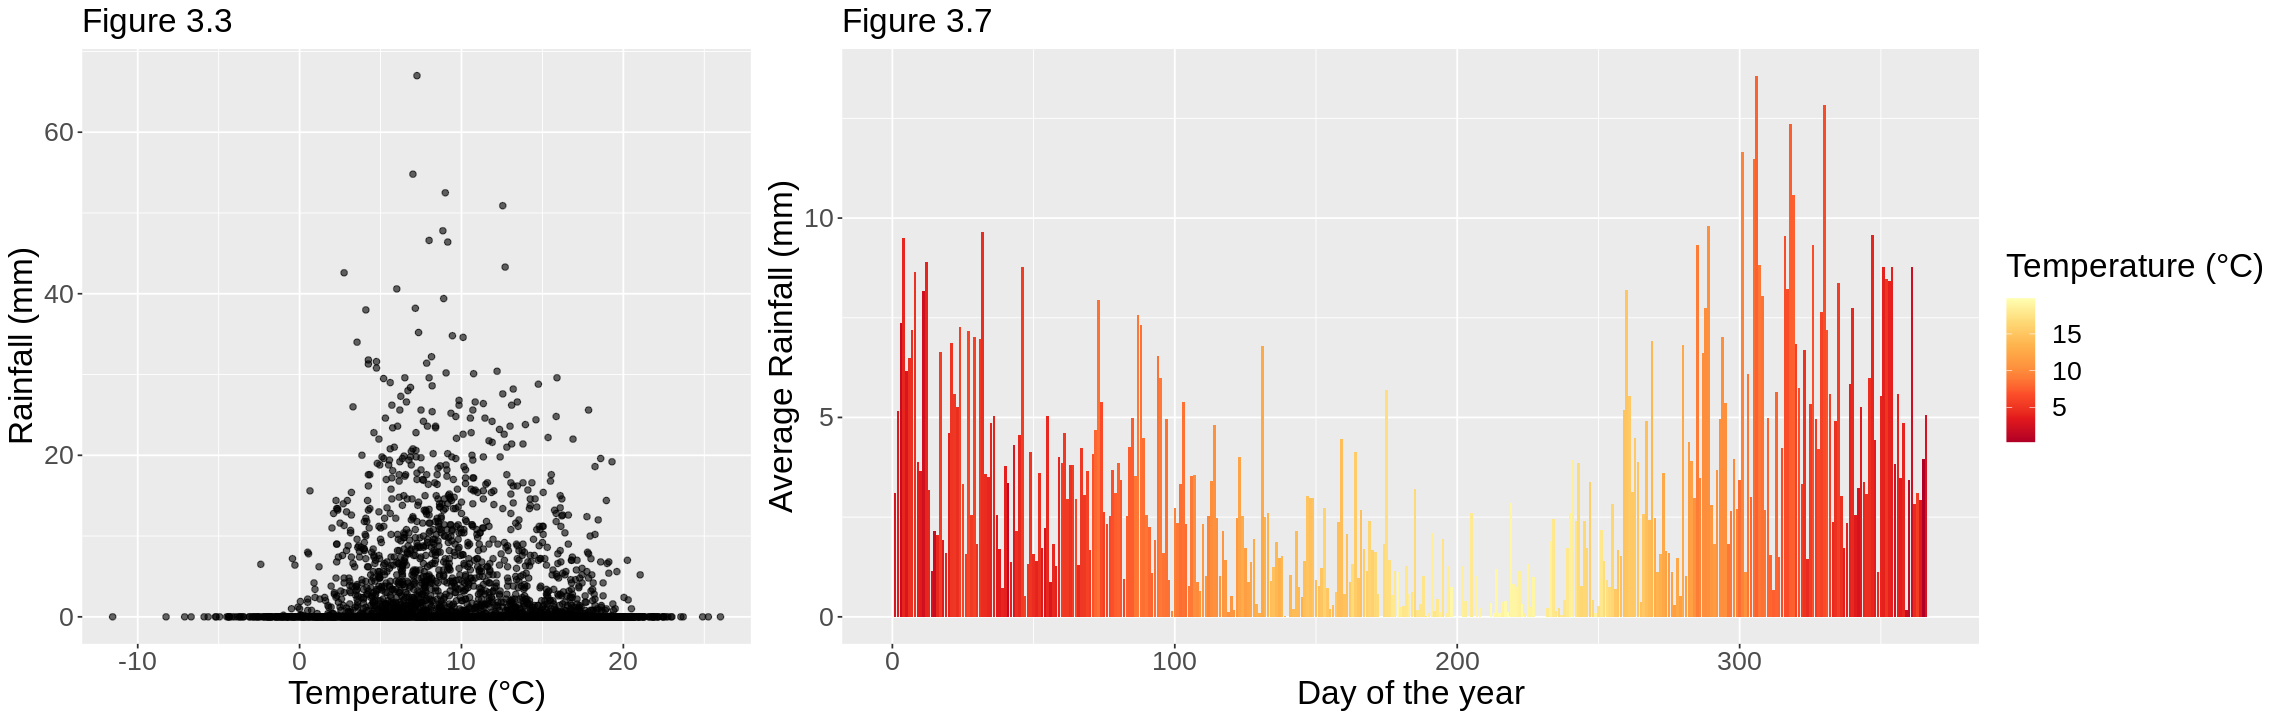

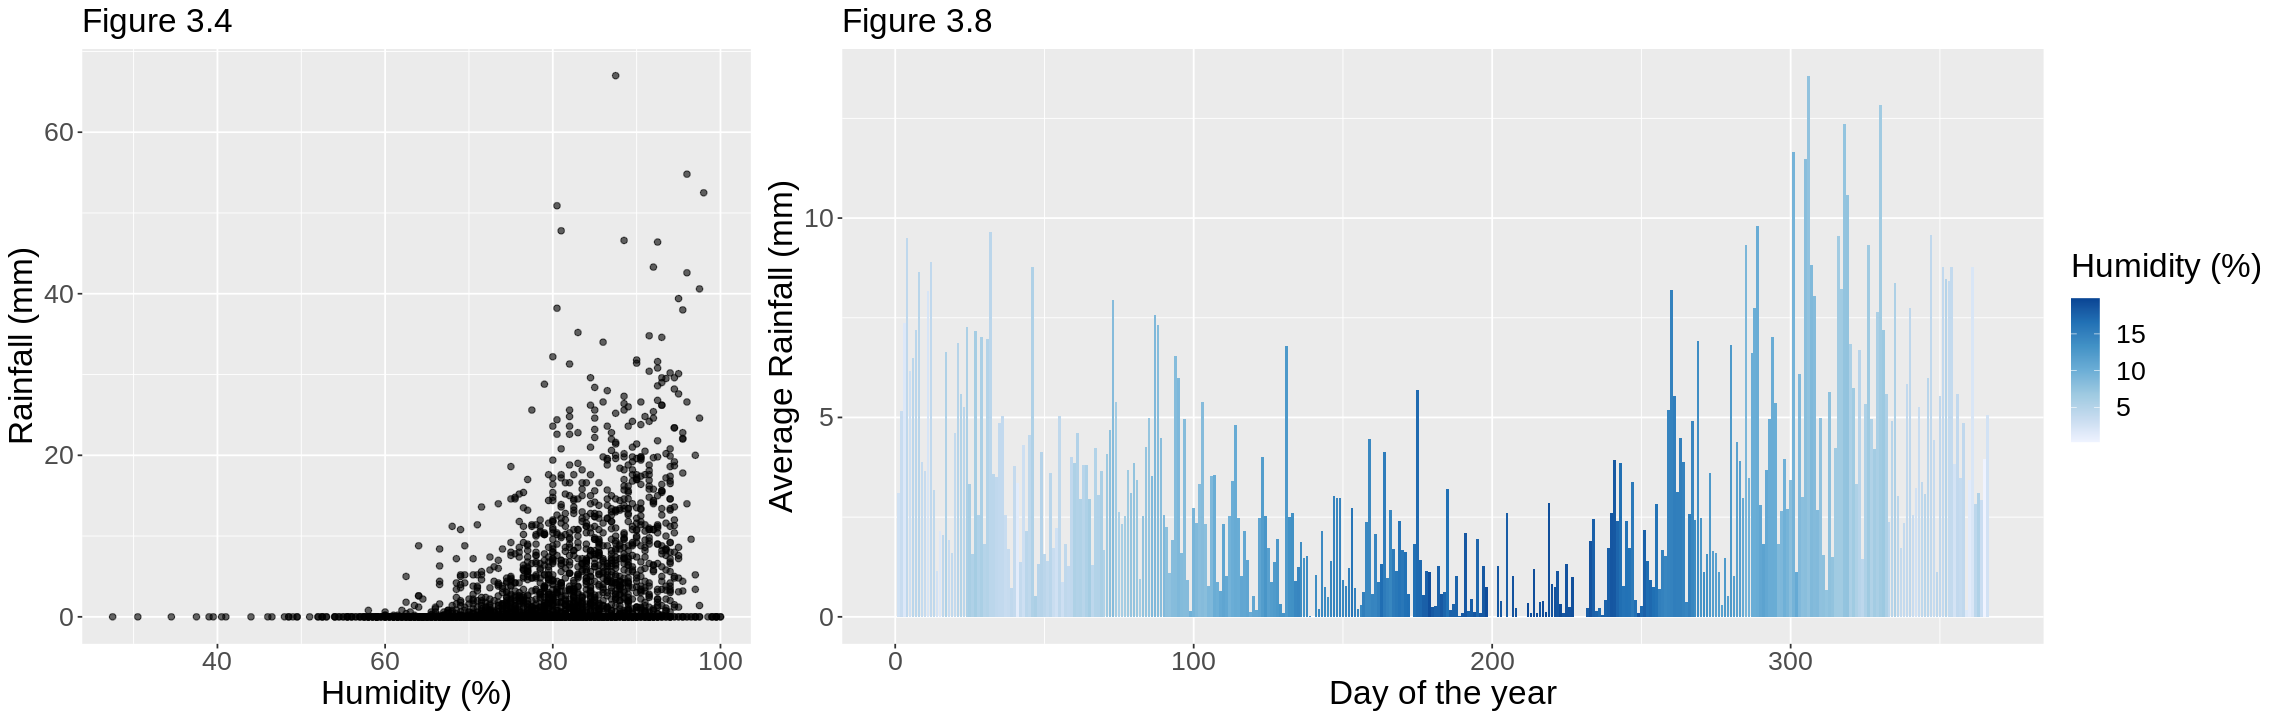

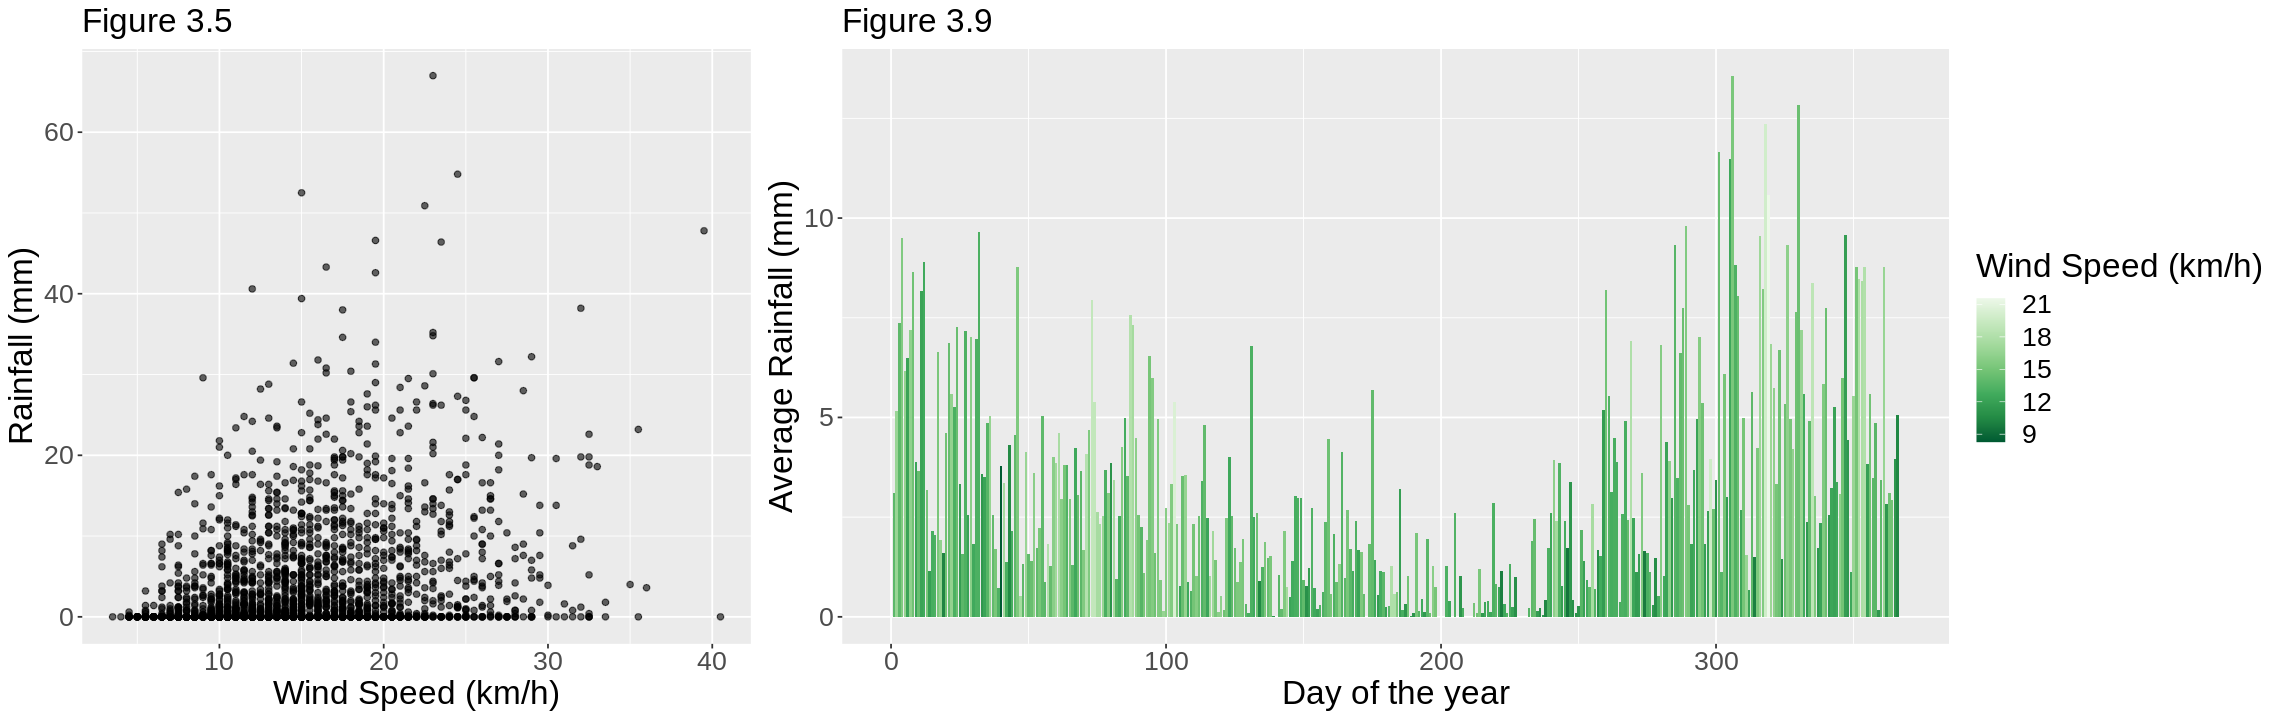

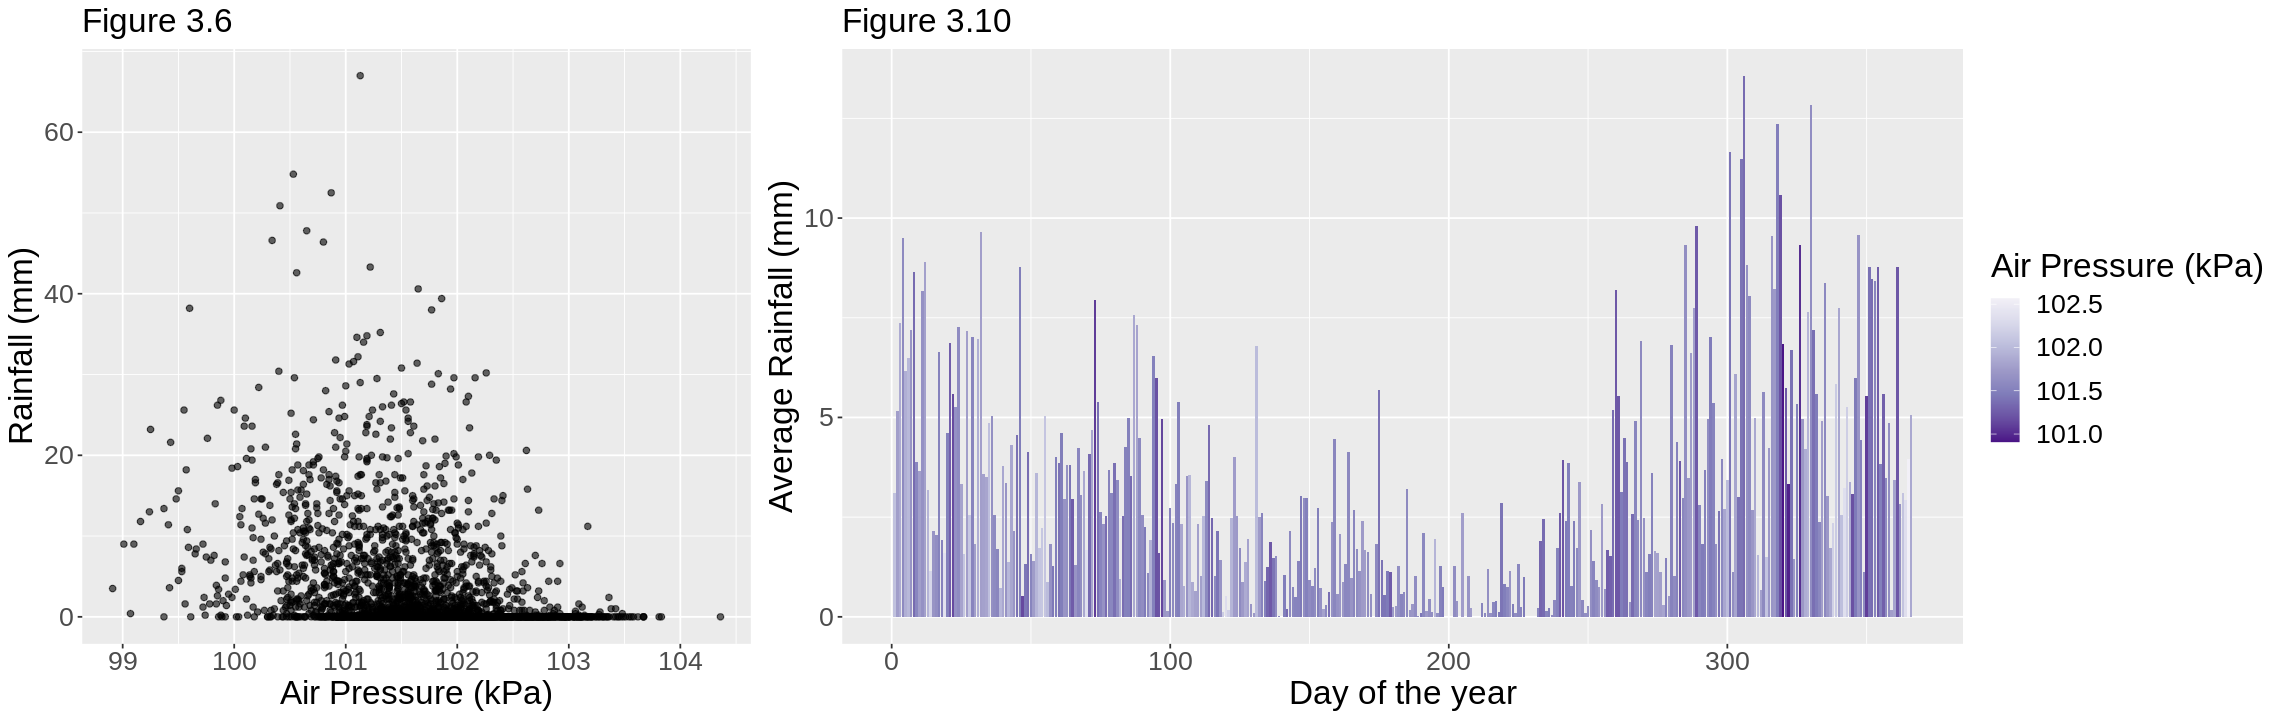

In [14]:
rain_temperature <- plot_grid(p1 = rain_temperature_plot, p2 = rain_temperature_over_time_plot, rel_widths = c(1, 2))
rain_temperature
rain_humidity <- plot_grid(p1 = rain_humidity_plot, p2 = rain_humidity_over_time_plot, rel_widths = c(1, 2))
rain_humidity
rain_wind <- plot_grid(p1 = rain_windspeed_plot, p2 = rain_windspeed_over_time_plot, rel_widths = c(1, 2))
rain_wind
rain_pressure <- plot_grid(p1 = rain_pressure_plot, p2 = rain_pressure_over_time_plot, rel_widths = c(1, 2))
rain_pressure

*Figures 3.3 to 3.10* show that all these variables have relationships with rainfall, and change with time. 
We now have a good set of predictor variables for our regression model: `yday + avg_temperature + avg_relative_humidity + avg_wind_speed + avg_pressure_station`,  corresponding to  the day of the year and the measurements for temperature, relative humidity, wind speed, and pressure.

### Prediction using _KNN_

We will use the **$K$-nearest-neighbors** regression algorithm to predict the amount of rainfall (mm). 

The shapes of the data seen in *Figures 3.2 to 3.6* display that our predictors do not have a linear relation with the output variable `rain`, so we cannot use a linear regression algorithm. _KNN_, not requiring any particular shape, would therefore be a logical choice. 

Our model would be supplied a new observation with measurements for temperature, relative humidity, wind speed, and pressure, as well as the day of the year. We must scale and center our predictors' values to ensure each predictor has an equal weighting on the prediction. The algorithm then calculates the Euclidean distance between this new observation and the existing training observations in our training data (`rain_training`), as if they were plotted in a 5-dimensional space (because we have 5 predictors), using the below formula:

$distance = \sqrt{(yday_{new} - yday)^2 \\+ (avg\_temperature_{new} - avg\_temperature)^2 \\+ (avg\_relative\_humidity_{new} - avg\_relative\_humidity)^2 \\+ (avg\_wind\_speed_{new} - avg\_wind\_speed)^2 \\+ (avg\_pressure\_station_{new} - avg\_pressure\_station)^2}$


The algorithm selects the  $K$ points with the least distance to our new point and calculates their average rainfall. 
To choose $K$, we will use cross validation to compare the expected ($RMSPE$) for various values of $K$, and pick the one with the lowest.

Finally, we will use our chosen $K$ value to predict rainfall using the predictor variables in our _testing_ dataset. This will be compared to the actual values to obtain the $RMSPE$ (Root Mean Squared Predicted Error) of our model. 

### Expected Outcomes and Significance


Our objective is to achieve an accurate regression model for predicting the rainfall amount for any given day of the year. If our model is accurate, it introduces a step in replacing the expensive numerical methods of weather forecasting used today, saving on computing power, and indirectly, fossil fuel usage. 

This exploration could also potentially shed light on the effects of Climate Change in Vancouver, which has become an important topic following events such as the 2021 [atmospheric river](https://www.uvic.ca/news/topics/2022+bc-floods-and-climate-change+news#:~:text=The%20powerful%20atmospheric%20river%20that,disaster%20in%20the%20province's%20history.) that caused severe flooding in many parts of the coast. If we notice our model becoming _more inaccurate_ in the coming years, this could suggest the occurrence of significant climate change. 

### Training our Model

First, we will create a preprocessing recipe for our data. As we have five predictors, we need to set all predictors to the same scales, to ensure each has an equal say in our prediction.

In [15]:
rain_recipe <- recipe(rain ~ yday + avg_temperature + avg_relative_humidity + avg_wind_speed + avg_pressure_station,
                      data = rain_training) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

Next, we create a model specification for K-nearest neighbors regression. We use `set_engine("kknn")` and `set_mode("regression")` to tell `tidymodels` to use _KNN_ Regression.

In [16]:
rain_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                set_engine("kknn") |>
                set_mode("regression") 

Then, we tune our model using 10-fold cross-validation. We chose to use 10 folds because it is a reasonable balance between the accuracy of the $RMPSE$ estimates, and the amount of time taken to run the cross-validation. We run this cross-validation for $K$ values from 1 to 100 and compare the estimated $RMSPE$ for each. 

In [17]:
rain_vfold <- vfold_cv(rain_training, v = 10, strata = rain)

gridvals <- tibble(neighbors = seq(1, 100))

rain_results <- workflow() |> 
    add_recipe(rain_recipe) |> 
    add_model(rain_spec) |>
    tune_grid(resamples = rain_vfold, grid = gridvals) |> 
    collect_metrics()

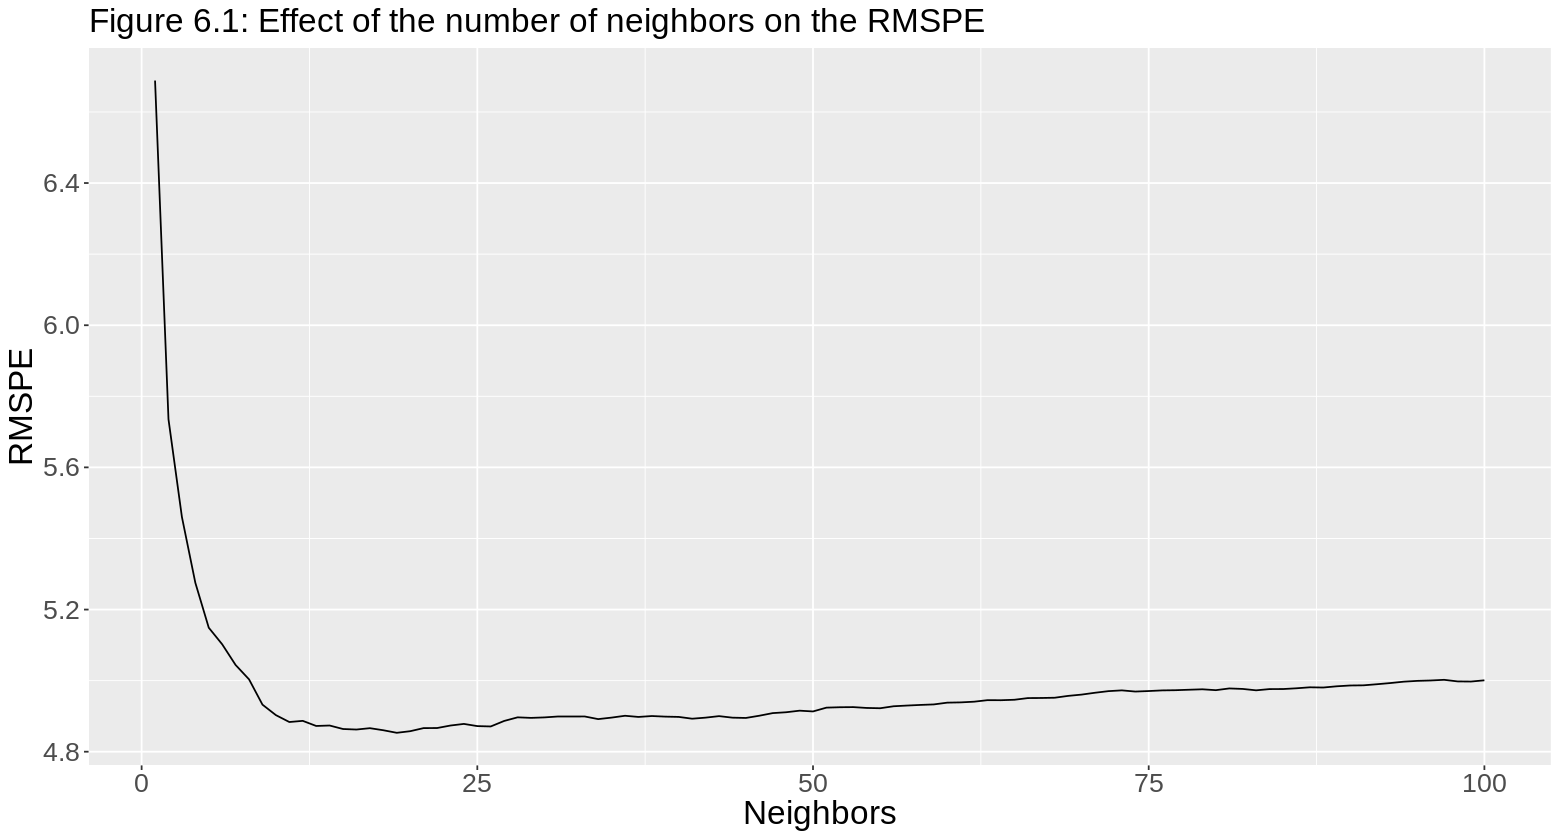

In [18]:
options(repr.plot.width = 13, repr.plot.height = 7)

rain_results <- rain_results |> filter(.metric == "rmse")
rain_results_plot <- ggplot(rain_results, aes(x = neighbors, y = mean)) +
                        geom_line() +
                        labs(x = "Neighbors", y = "RMSPE", subtitle = "Figure 6.1: Effect of the number of neighbors on the RMSPE") +
                        theme(text = element_text(size = 20))
rain_results_plot

*Figure 6.1* visualizes how the estimated $RMSPE$ varies with the number of neighbors $K$. As no lucky spikes seem to appear, we shall take the $K$ value that gave the minimum $RMSPE$. 

In [19]:
k_min <- rain_results |>
            arrange(mean) |>
            head(1) |>
            select(neighbors) |>
            pull()
k_min

[1] 19

The minimum $RMSPE$ occurs when $K = 19$. We now build our 'best' model by re-training the model on the entire training data set using $K = 19$.

In [20]:
rain_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

rain_best_fit <- workflow() |>
         add_recipe(rain_recipe) |>
         add_model(rain_best_spec) |>
         fit(data = rain_training)

We now apply this model to predict rainfall for observations in our testing data.

In [21]:
rain_pred <- rain_best_fit |>
          predict(rain_testing) |>
          bind_cols(rain_testing)
          
head(rain_pred)

.pred,date,avg_hourly_temperature,avg_temperature,avg_hourly_relative_humidity,avg_relative_humidity,avg_hourly_dew_point,avg_dew_point,avg_hourly_wind_speed,avg_wind_speed,⋯,avg_hourly_health_index,avg_health_index,avg_hourly_cloud_cover_4,avg_cloud_cover_4,avg_hourly_cloud_cover_8,avg_cloud_cover_8,avg_hourly_cloud_cover_10,avg_cloud_cover_10,rain,yday
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1368421,2011-01-01,-1.62,-1.55,76.1,74.0,-5.5,-5.5,1.58,5.5,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.0,1
0.4578947,2011-01-02,-1.08,-1.30,82.6,81.5,-3.7,-3.5,4.42,9.5,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.0,2
9.4578947,2011-01-05,3.39,3.55,92.6,92.0,2.3,2.5,18.12,19.5,⋯,2.7,2.5,NA,NA,NA,NA,NA,NA,23.8,5
5.2947368,2011-01-08,3.45,2.95,83.1,83.0,0.9,0.8,20.88,19.5,⋯,2.1,2.5,NA,NA,NA,NA,NA,NA,0.0,8
0.3368421,2011-01-22,5.79,5.20,84.8,84.0,3.4,3.0,7.71,8.5,⋯,2.2,2.5,NA,NA,NA,NA,NA,NA,0.4,22
6.1631579,2011-01-24,6.84,6.90,94.0,93.5,5.9,5.8,12.17,13.0,⋯,2.5,2.5,NA,NA,NA,NA,NA,NA,30.4,24


###### *Table 6.1: Predicted value results on testing data*

### Results and Discussion

*Table 6.1* shows the `rain_pred` table with the actual (unseen) `rain` values, along with the newly affixed `.pred` column containing our model's rainfall predictions. To judge the quality of our regression model, we will employ `metrics()` to compute the $RMSPE$ between the actual values and predicted values.

In [22]:
rain_summary <- rain_pred |>
                metrics(truth = rain, estimate = .pred)
rain_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.612065
rsq,standard,0.464377
mae,standard,2.445030


###### *Table 7.1: Summary of regression quality on testing data*

*Table 7.1* indicates our $RMSPE$ value is ~4.61 mm of rainfall. Condering that rainfall can range from 0-65 mm (*Figure 3.1*), a 4.61 mm error is reasonable. However, rainfall is a dynamic thing, and varies throughout the year, so the $RMSPE$ value alone is not a great indicator of our model's accuracy. 

Instead, let's visualize our model seperately for the years 2013, 2018, and 2020, to analyze our model's performance. We chose these years as they had low, medium, and high total rainfall values respectively (See *Table 2.3*). Since we cannot visualize a 5 dimensional graph with all of our predictors, we plotted rainfall against time for interpretability.

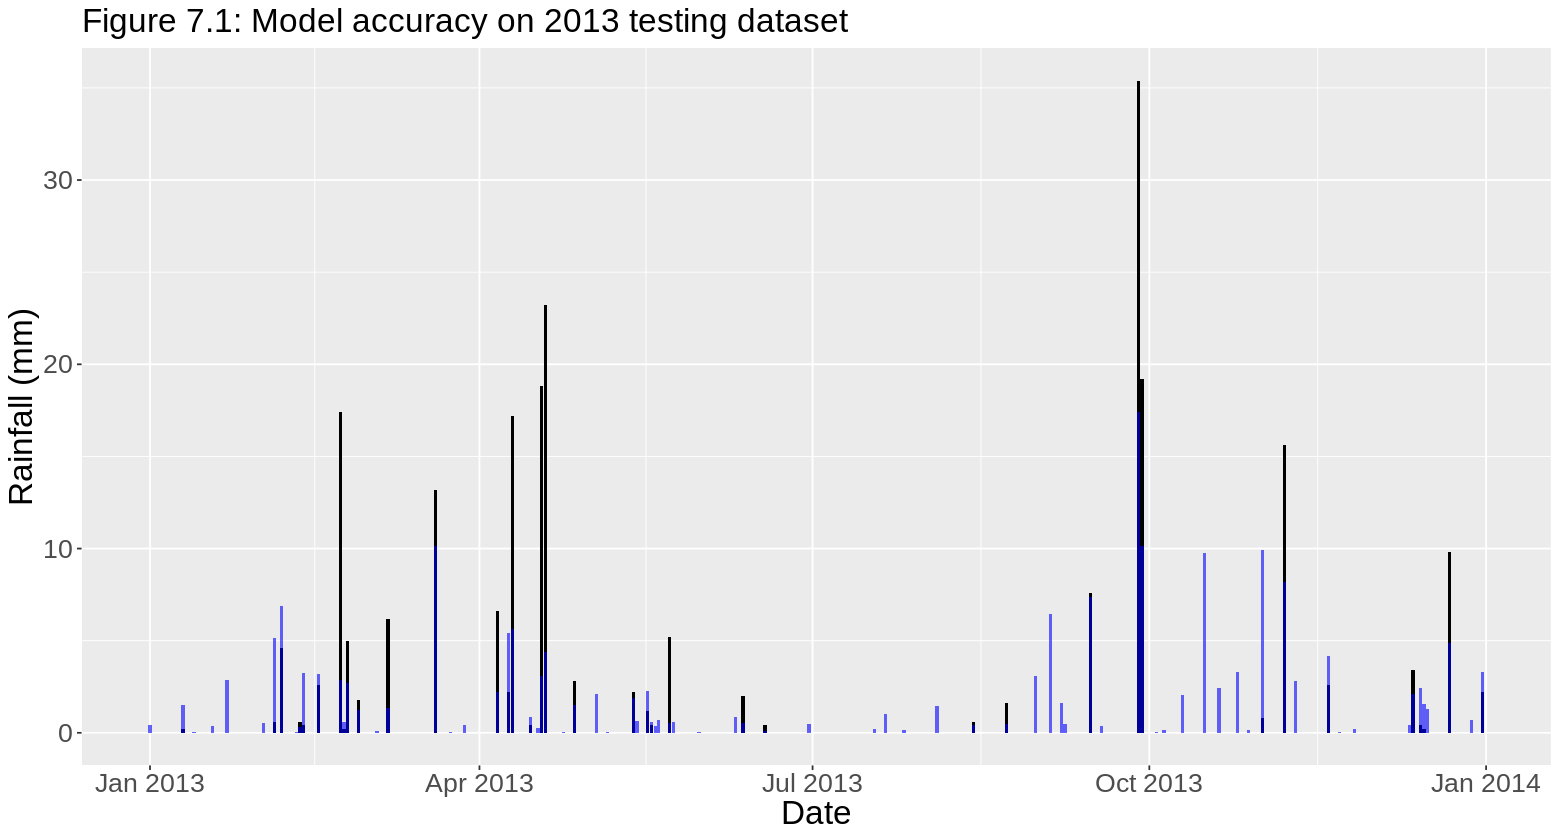

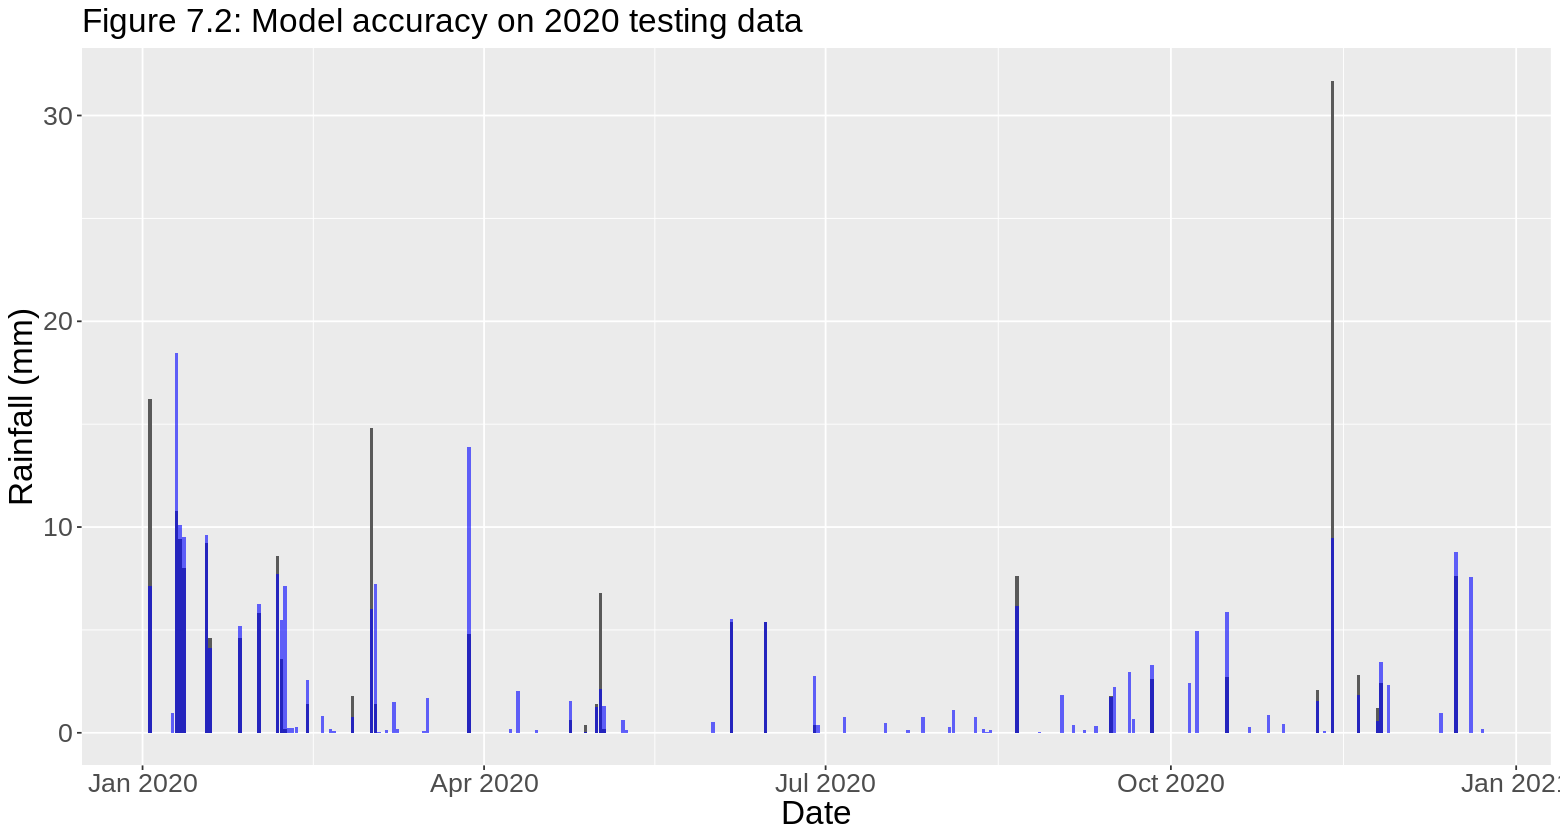

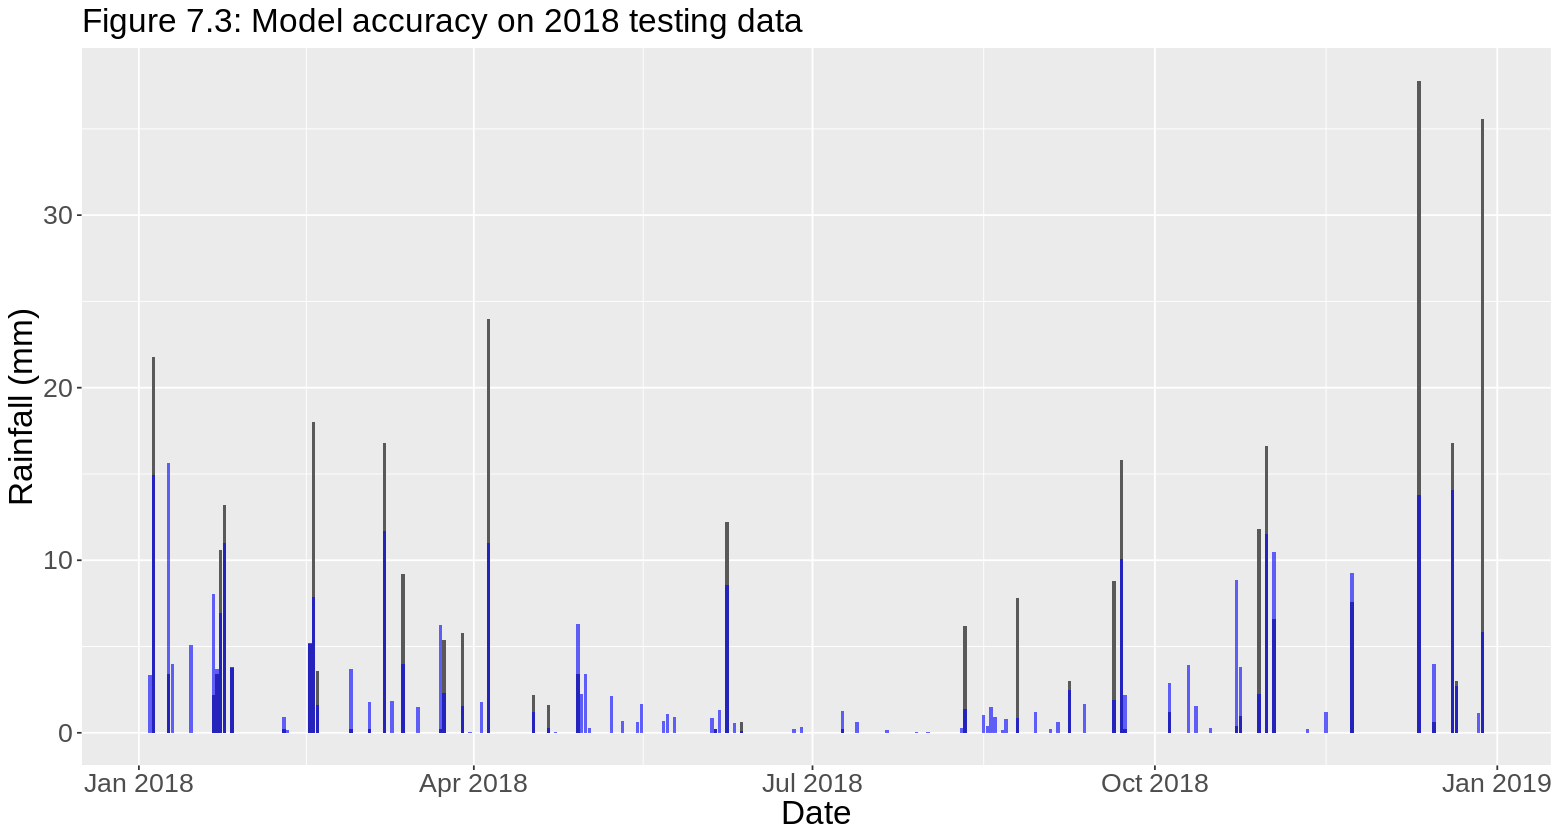

In [23]:
options(repr.plot.width = 13, repr.plot.height = 7)

skyblue <- "skyblue"

rain_pred_2014_plot <- ggplot(filter(rain_pred, year(date) == 2013)) + 
                        geom_bar(stat = "identity", aes(x = date, y = rain), fill = "black") +
                        geom_bar(stat = "identity", aes(x = date, y = .pred), fill = "blue", alpha = 0.6) +
                        labs(x = "Date", y = "Rainfall (mm)", alpha = "Legend", subtitle = "Figure 7.1: Model accuracy on 2013 testing dataset") +
                        #scale_x_date(date_labels = "%B", date_breaks = "1 month") +
                        theme(text = element_text(size = 20))

rain_pred_2020_plot <- ggplot(filter(rain_pred, year(date) == 2020)) + 
                        geom_bar(stat = "identity", aes(x = date, y = rain)) +
                        geom_bar(stat = "identity", aes(x = date, y = .pred), fill = "blue", alpha = 0.6) +
                        labs(x = "Date", y = "Rainfall (mm)", alpha = "Legend", subtitle = "Figure 7.2: Model accuracy on 2020 testing data") +
                        #scale_x_date(date_labels = "%B", date_breaks = "1 month") +
                        theme(text = element_text(size = 20))

rain_pred_2019_plot <- ggplot(filter(rain_pred, year(date) == 2018)) + 
                        geom_bar(stat = "identity", aes(x = date, y = rain)) +
                        geom_bar(stat = "identity", aes(x = date, y = .pred), fill = "blue", alpha = 0.6) +
                        labs(x = "Date", y = "Rainfall (mm)", alpha = "Legend", subtitle = "Figure 7.3: Model accuracy on 2018 testing data") +
                        #scale_x_date(date_labels = "%B", date_breaks = "1 month") +
                        theme(text = element_text(size = 20))

rain_pred_2014_plot
rain_pred_2020_plot
rain_pred_2019_plot

In *Figures 7.1 to 7.3*, we compare our predicted output (blue) to the actual rainfall amounts (grey) for each day in our testing data. We can see from the above visualization that our model does a good job at capturing general trends in rainfall - in most cases, the pattern of the predicted rainfall seems to closely follow that of the actual rainfall. On days when there is no/low rainfall, our model too predicts very low values of rainfall (one exception being October 2013). On days with medium (5 to 10 mm) of rainfall, our model is quite accurate. On days with very high values (> 10 mm) of rainfall, our model does predict high values but underpredicts the actual amount. This could be a danger during storms, as our model would likely fail to give the necessary storm warnings.

Let us also try to predict the values of rainfall for 2022, to see how our model would perform with completely new, future observations. Since 2022 isn't over yet, we cannot fairly compute an RMSPE, since more rainfall could occurr towards the end of December. However, we can visually compare the predictions with the actual values, to get an idea of how well our model predicts the rainfall pattern. We will load 2022 (till Dec 2) rainfall data from the same source, and fit our `rain_best_fit` prediction model onto it:

In [24]:
rain_data_2022 <- read_csv("https://raw.githubusercontent.com/taimagher/Weather-Stats-Report/main/weatherstats_vancouver_daily_2022.csv") |>
                    filter(year(date) == 2022) |>
                    mutate(yday = yday(date))
rain_pred_2022 <- rain_best_fit |>
                  predict(rain_data_2022) |>
                  bind_cols(rain_data_2022)

Rows: 1000 Columns: 70
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (58): max_temperature, avg_hourly_temperature, avg_temperature, min_tem...
lgl   (9): solar_radiation, max_cloud_cover_4, avg_hourly_cloud_cover_4, avg...
date  (1): date
time  (2): sunrise, sunset

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
“Removed 1 rows containing missing values (position_stack).”


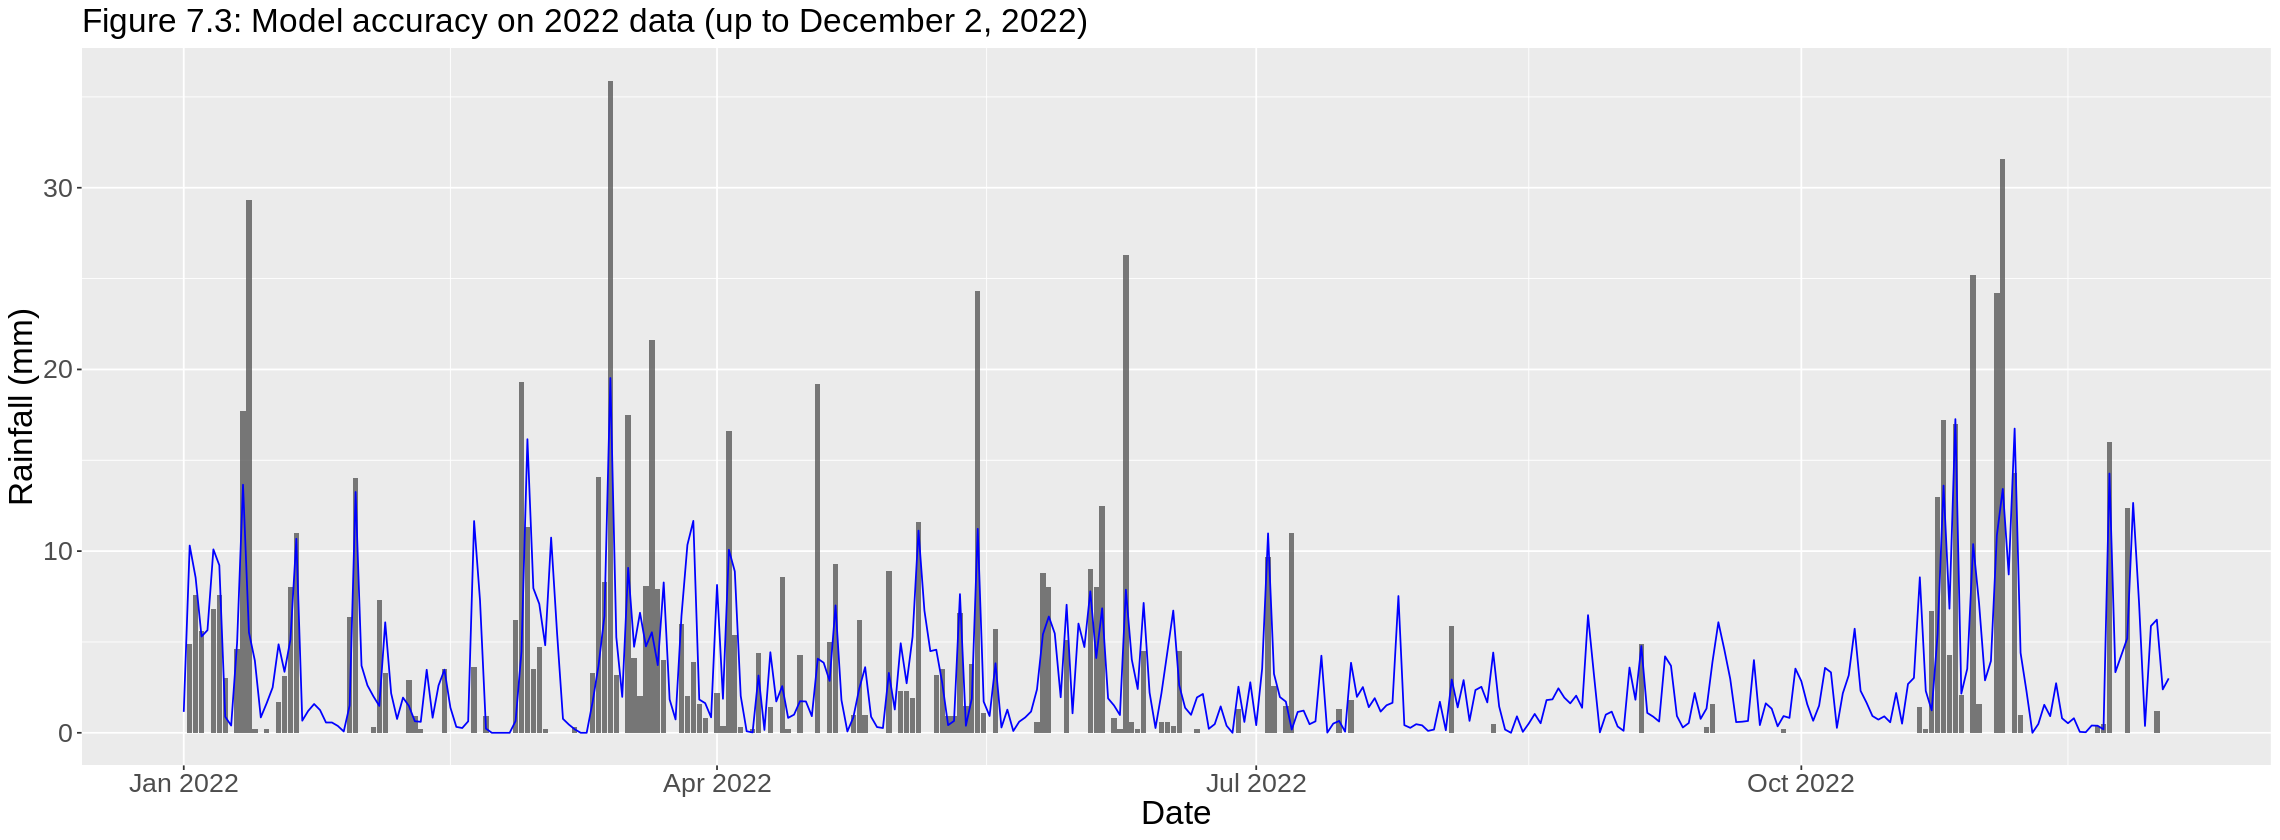

In [25]:
options(repr.plot.width = 19)

rain_pred_2022_plot <- ggplot(rain_pred_2022) + 
                        geom_bar(stat = "identity", aes(x = date, y = rain), alpha = 0.8) +
                        geom_line(aes(x = date, y = .pred), color = "blue") +
                        labs(x = "Date", y = "Rainfall (mm)", alpha = "Legend", subtitle = "Figure 7.3: Model accuracy on 2022 data (up to December 2, 2022)") +
                        #scale_x_date(date_labels = "%B", date_breaks = "1 month") +
                        theme(text = element_text(size = 20))
rain_pred_2022_plot

*Figure 7.3* compares the actual rainfall amount (grey bars), with our model's prediction for the same (blue line). We used a line this time because this is new data that we haven't split into training and testing, so it actually contains values for each day of the 2022 so far. This makes it almost continuous, and plotting two layers of bars here would've made it too crowded. Our model visibly predicts the rainfall pattern quite well, with many middle and low values predicted almost exactly. In August and September, there is some overprediction visible - our model predicts small amounts of rain when there was actually no rain. There is also a stretch of over-prediction in October 2022, but it is worth noting that even the National Centers for Environmental Information reports that October 2022 was drier than initially expected<sup>[6]</sup>, so this error could be due to climate anomalies, rather than faults in our model. This information isn't enough to conclude that this is indeed the cause of our inaccuracy, but it is an interesting observation. We discuss more about climate anomalies' effects on our model in the next section of our Report.

### Future Prospects

Returning to our research question: can machine learning based models could replace conventional expensive numerical models for weather prediction? We argue that the fact that our model could closely capture patterns in the rainfall as a good sign. Regular weather prediction uses supercomputers, and still is not perfect. Our model can be run using an R Kernel on a _home_ computer.
Additionally, our model used KNN Regression (one of the simplest regression algorithms), and still got a decent $RMSPE$ - a promising sign of achieving even better accuracies with more advanced regression algorithms. Overall, these results suggest strong potential for machine learning in meteorology and forecasting.

One interesting point to consider is whether the dynamic nature of weather could lead to a change in our model's accuracy over time? _KNN_ Regression fundamentally predicts values using data it has been trained with. If, for instance, the new observation was anomalous, and did not follow the pattern of the training data, the prediction would be quite inaccurate. We hence hypothesize that one factor that could be contributing to our $RMSPE$ is in fact, anomalous weather. 

While we may not be able to conclusively prove this, we can use some context to see if this is a plausible explanation.

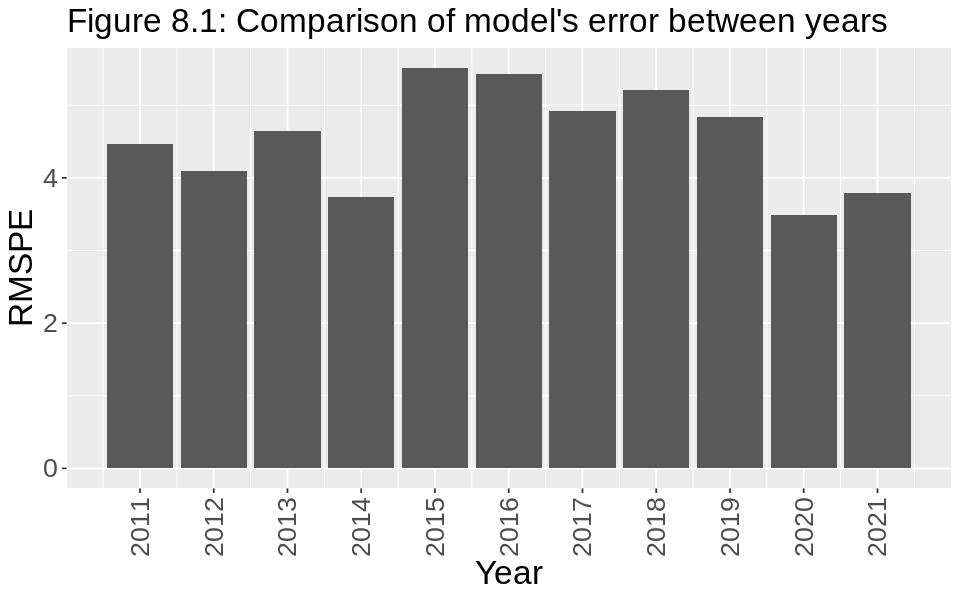

In [26]:
options(repr.plot.width = 8, repr.plot.height = 5)
climate_change_yearly_plot <- rain_pred |>
                        group_by(year(date)) |>
                        summarize(rmspe = sqrt(mean((.pred - rain)^2))) |>
                        ggplot(aes(x = `year(date)`, y = rmspe)) +
                        geom_bar(stat = 'identity') +
                        labs(x = "Year", y = "RMSPE", subtitle = "Figure 8.1: Comparison of model's error between years") +
                        theme(text = element_text(size = 20), axis.text.x = element_text(angle = 90, vjust = 0.5)) +
                        scale_x_continuous("Year", breaks = c(2011:2021))
climate_change_yearly_plot

*Figure 8.1* shows the $RMSPE$ of our model separately for each year in the dataset. It is visible that the year with the highest $RMSPE$ on average, i.e. the most inaccurate year for our model's predictions, was 2015. 2015 was labelled a very anomalous year for weather patterns by climate change researchers<sup>[7]</sup>. Again, we see correlation between anomalous climate, and our model's inaccuracy. Could our model, then, be used as an indicator for climate change? We could use our model to predict Vancouver rainfall for the upcoming decade, and plot a new comparison of $RMSPE$ by year, similar to Figure 8.1. If we see that the $RMSPE$ value is steadily increasing, we _theorize_ that climate change could contributing to the increased error.

Nevertheless, our model shows promising results, and we recommend more research into using machine learning algorithms to predict the weather. Note that our model has only dealt with rainfall, but it is worth developing similar models for predicting snow and other weather phenomena to see how accurate the results are.
Soon, we could be replacing old, slow, expensive numerical weather prediction methods with lighter and more affordable machine learning models. We hope to someday use machine learning to provide timely, reliable weather predictions to the residents of Vancouver, and perhaps even the rest of the world.

   ### Works Cited 

1. Government of Canada. “1981-2010 Climate Normals & Averages.” Canada.ca, 31 Oct. 2011, climate.weather.gc.ca/climate_normals/.
2. Schumacher, Russ & Hill, Aaron. “AI and Machine Learning Are Improving Weather Forecasts, but They Won’t Replace Human Experts.” Colarado State University, 26 May 2022, source.colostate.edu/ai-and-machine-learning-are-improving-weather-forecasts-but-they-wont-replace-human-experts/ 
3. Vancouver Weather Stats. “Data Download for Vancouver.” Amateur Weather Statistics for Vancouver, British Columbia, vancouver.weatherstats.ca/download.html.
4. Timbers, T., Campbell, T., & Lee, M. (2022). Data science: A first introduction. CRC Press LLC.
5. National Oceanic and Atmospheric Administration. “Weather Observations.” NOAA, 1 Feb. 2011, www.noaa.gov/education/resource-collections/weather-atmosphere/weather-observations.
6. National Oceanic and Atmospheric Administration. “October 2022 Global Climate Report | National Centers for Environmental Information (NCEI).” Nov. 2022, www.ncdc.noaa.gov/sotc/global/202210.
7. Pidwirny, Michael, et al. The Blob Winter of 2015 | Michael Pidwirny - University of Climate Daily/Forecast/Sun British Columbia. blogs.ubc.ca/michaelpidwirny/theblob/.